# A Multiagent transportation system

Auteur : Philippe Mathieu, [CRISTAL Lab](https://www.cristal.univ-lille.fr/), [SMAC Team](https://www.cristal.univ-lille.fr/?rubrique26&id=7), [University of Lille](http://www.univ-lille1.fr), email : philippe.mathieu@univ-lille.fr

Contributeurs : Corwin Fèvre (CRISTAL/SMAC , CRISTAL/OSM)

Creation : 15/01/2020


## Principe général


Cette feuille fait suite à [mas_basics_fr.ipynb](mas_basics_fr.ipynb) qui donnait les bases de la construction d'un système multi-agents sur un reseau social.
Nous vous montrons ici, comment réaliser une petite simulation d'un système de co-voiturage à l'aide des agents.

## Un système séquentiel

Dans sa forme la plus simple, un agent est une entité dotée d'une seule
capacité, celle de décider quoi faire. Personne ne lui indique ce qu'il doit faire,
c'est lui qui décide ! C'est le principe d'**autonomie**. Il suffit juste de lui donner la
parole pour qu'il agisse. Lors de sa prise de parole, l'agent réalise sémantiquement 3 étapes différentes : la **perception** de son entourage, la **decision** en fonction de son propre état et de ce qu'il a perçu, puis l'**action** effective qu'il réalise in fine. Idéalement chaque agent ne peut faire qu'une seule action lors de sa prise de parole.

In [289]:
class Agent:
      def __init__(self,name) :
          self.name=name
        
      def decide(self):
          print("Bonjour ! My name is "+self.name)

Il est bien sûr possible de créer plusieurs agents et de les interroger directement.

In [290]:
a1 = Agent("philippe")
a2 = Agent("corwin")
a1.decide()
a2.decide()

Bonjour ! My name is philippe
Bonjour ! My name is corwin


### Le système multiagent séquentiel

Bien évidemment, un système multi-agent utilise des dizaines voire des
milliers d'agents. Il est alors necessaire de créer une classe
permettant de les manager. En général la méthode qui lance la
simulation se nomme `run` et prend en paramètre le nombre de prises de
paroles.
Afin d'assurer le principe d'**équité** on s'assure que chaque agent a
au moins une fois la parole avant qu'un autre agent ne l'ait deux
fois. On s'appuie pour cela sur la notion de tour de parole. Chaque tour de
parole donne aléatoirement la parole à l'ensemble des agents, avant de
recommencer. Un tour de parole constitue sémantiquement une unité de temps, un tick d'horloge. La classe SMA s'écrit :


In [291]:
import random
class SMA:
      def __init__(self):
        self.tick=0
        self.resetTicks()
        self.agentList = []

      def resetTicks(self):
          tick=0
          
      def addAgent(self,ag):
          self.agentList.append(ag)
 
      def run(self,rounds):
          for i in range(0,rounds):
              self.runOnce()

      def runOnce(self):
          self.tick+=1
          random.shuffle(self.agentList)
          for ag in self.agentList :
              ag.decide()
          print("tick "+str(self.tick)+" ended")

In [292]:
sma = SMA()
sma.addAgent(Agent("paul"))
sma.addAgent(Agent("kim"))
sma.run(6)

Bonjour ! My name is paul
Bonjour ! My name is kim
tick 1 ended
Bonjour ! My name is paul
Bonjour ! My name is kim
tick 2 ended
Bonjour ! My name is kim
Bonjour ! My name is paul
tick 3 ended
Bonjour ! My name is paul
Bonjour ! My name is kim
tick 4 ended
Bonjour ! My name is kim
Bonjour ! My name is paul
tick 5 ended
Bonjour ! My name is paul
Bonjour ! My name is kim
tick 6 ended


### La simultanéïté

Le système séquentiel présenté précédemment possède des avantages mais aussi des inconvénients. Parmi ses avanatages, il y a bien évidemment sa simplicité. Il possède néanmoins un inconvénient lié au fait que comme un agent agit dès qu'il le peut (dans sa méthode `decide`), deux agents évalués consécutivement ne sont donc pas face au même état de l'environnement.

Prenons un simple exemple d'agents qui raisonnent sur le nombre d'appels total qu'il y a eu à une des méthodes `decide`. Chacun incrémente ce nombre d'appel global, mais aucun d'entre eux ne perçoit la même valeur.


In [293]:
global_calls = 0

class Agent:
    def __init__(self,name) :
        self.name=name
            
    def decide(self):
        global global_calls
        global_calls += 1
        print("Je suis ",self.name, "et je pense que le nombre global est ", global_calls) 

sma = SMA()
sma.addAgent(Agent("Paul"))
sma.addAgent(Agent("Kim"))
sma.addAgent(Agent("Lisa"))
sma.run(6)

Je suis  Kim et je pense que le nombre global est  1
Je suis  Paul et je pense que le nombre global est  2
Je suis  Lisa et je pense que le nombre global est  3
tick 1 ended
Je suis  Kim et je pense que le nombre global est  4
Je suis  Paul et je pense que le nombre global est  5
Je suis  Lisa et je pense que le nombre global est  6
tick 2 ended
Je suis  Kim et je pense que le nombre global est  7
Je suis  Paul et je pense que le nombre global est  8
Je suis  Lisa et je pense que le nombre global est  9
tick 3 ended
Je suis  Kim et je pense que le nombre global est  10
Je suis  Paul et je pense que le nombre global est  11
Je suis  Lisa et je pense que le nombre global est  12
tick 4 ended
Je suis  Lisa et je pense que le nombre global est  13
Je suis  Paul et je pense que le nombre global est  14
Je suis  Kim et je pense que le nombre global est  15
tick 5 ended
Je suis  Lisa et je pense que le nombre global est  16
Je suis  Kim et je pense que le nombre global est  17
Je suis  Paul e

On voir clairement ici la différence de niveau d'information des différents agents au sein d'un même tour de parole.

Dans certaines simulations, il est parfois necessaire que, dans un même tour de parole, tous les agents soient face à la même connaissance lors de leur raisonnement. C'est le principe d'équité en raisonnement, ou en d'autres termes, *la simultanéïté* dans l'action (problème similaire à celui des automates cellulaires : dans le célèbre `jeu de la vie`, toutes les cellules changent d'état simultanément).

Pour implémenter ce principe de simultanéité, le principe perception-decision-action doit être "ventilé". L'agent a alors besoin de 2 méthodes d'accès. La première pour la perception et la décision : `update`  et la seconde pour l'action :`decide`.
Le SMA appelle alors `update` chez tous les agents, puis `decide`. La connaissance étant identique pour tous au moment du raisonnement, l'ordre de passage des agents est maintenant indifférent : ils peuvent tous agir dans le même ordre.

In [294]:
global_calls = 0 

class Agent:
    def __init__(self,name) :
        self.name=name

    def update(self) :
        global global_calls 
        global_calls += 1
        
    def decide(self):
        print("Je suis ",self.name, "et je pense que le nombre global est ", global_calls)

In [295]:
import random
class SMA:
    def __init__(self):
        self.tick=0
        self.resetTicks()
        self.agentList = []

    def resetTicks(self):
        tick=0
          
    def addAgent(self,ag):
        self.agentList.append(ag)
 
    def run(self,rounds):
        for i in range(0,rounds):
            self.runOnce()

    def runOnce(self):
        self.tick+=1
        for ag in self.agentList :
            ag.update()
        for ag in self.agentList :
            ag.decide()            
        print("tick "+str(self.tick)+" ended")

In [296]:
sma = SMA()
sma.addAgent(Agent("Paul"))
sma.addAgent(Agent("Kim"))
sma.addAgent(Agent("Lisa"))
sma.run(3)

Je suis  Paul et je pense que le nombre global est  3
Je suis  Kim et je pense que le nombre global est  3
Je suis  Lisa et je pense que le nombre global est  3
tick 1 ended
Je suis  Paul et je pense que le nombre global est  6
Je suis  Kim et je pense que le nombre global est  6
Je suis  Lisa et je pense que le nombre global est  6
tick 2 ended
Je suis  Paul et je pense que le nombre global est  9
Je suis  Kim et je pense que le nombre global est  9
Je suis  Lisa et je pense que le nombre global est  9
tick 3 ended


Cette fois on constate que tous les agents ont eu la même information dans un même tour de parole.

La simultanéïté des agents résoud parfois certains problèmes, mais elle possède évidemment un inconvénient majeur. Si les ressources accédées par les agents sont communes, il y a alors risque de conflit, et il faudra alors régler les conflits. C'est pourquoi le principe de simultanéïté n'est utilisé dans les SMA que lorsque c'est vraiment necessaire.

Quand des agents `véhicules` circulent sur infrastructure, le SMA leur permet régulièrement d'avancer en fonction de ce qu'ils perçoivent. Dans un tel cas, on comprend aisément que l'ordre de raisonnement des agents devient capital : Si A est devant B et que tous deux sont très proches et à la même vitesse, si A avance en premier, B n'a ensuite aucune difficulté à avancer, tandis que si B avance en premier, l'accident est inévitable. la simultanéïté devient alors impérative.



# La simulation du trafic

On souhaite ici concevoir un générateur de trafic routier rudimentaire. Dans ce modèle, des agents `CarAgent` circulent sur une infrastructure routiere simplifiée constituée d'une grille abstraite de `n` verticales et `m` horizontales. Cette grille sera simplement matérialisée par ses bornes `bounds(n,m)`. Nos véhicules passent simplement d'une intersection à la suivante. Ils ont donc une position (x,y) sur la grille.

A chaque étape, le véhicule suit son itinéraire.

In [297]:
import random
class CarAgent():
    def __init__(self, unique_id, pos_dep, pos_arr):
        self.pos = pos_dep
        self.pos_arr = pos_arr
        self.is_alive = True
        self.unique_id = unique_id
        
    def decide(self):
        if self.pos[0] == self.pos_arr[0]:
            if self.pos[1] == self.pos_arr[1]:
                #arrivé à destination
                self.is_alive = False
                print("agent "+str(self.unique_id)+ " died")
                return
            elif self.pos[1] > self.pos_arr[1]:
                self.new_pos = (self.pos[0],self.pos[1]-1)
            else :
                self.new_pos = (self.pos[0],self.pos[1]+1)
        elif self.pos[0] > self.pos_arr[0]:
            self.new_pos = (self.pos[0]-1,self.pos[1])
        else :
            self.new_pos = (self.pos[0]+1,self.pos[1])
            
        print("Agent voiture n°",self.unique_id,"bouge de",self.pos,"à",self.new_pos)
        self.pos = self.new_pos
        

In [298]:
agentList = [CarAgent(1,(2,0),(4,0)) , CarAgent(2,(5,5), (7,9)), CarAgent(3,(8,8), (4,6))]
tick = 0
for _ in range(7):
    random.shuffle(agentList)
    for a in agentList :
        a.decide()
        
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            agentList.remove(a) 
    print("tick",tick,"ended\n")
    tick+=1
        

Agent voiture n° 1 bouge de (2, 0) à (3, 0)
Agent voiture n° 3 bouge de (8, 8) à (7, 8)
Agent voiture n° 2 bouge de (5, 5) à (6, 5)
tick 0 ended

Agent voiture n° 1 bouge de (3, 0) à (4, 0)
Agent voiture n° 3 bouge de (7, 8) à (6, 8)
Agent voiture n° 2 bouge de (6, 5) à (7, 5)
tick 1 ended

Agent voiture n° 3 bouge de (6, 8) à (5, 8)
agent 1 died
Agent voiture n° 2 bouge de (7, 5) à (7, 6)
tick 2 ended

Agent voiture n° 2 bouge de (7, 6) à (7, 7)
Agent voiture n° 3 bouge de (5, 8) à (4, 8)
tick 3 ended

Agent voiture n° 2 bouge de (7, 7) à (7, 8)
Agent voiture n° 3 bouge de (4, 8) à (4, 7)
tick 4 ended

Agent voiture n° 2 bouge de (7, 8) à (7, 9)
Agent voiture n° 3 bouge de (4, 7) à (4, 6)
tick 5 ended

agent 3 died
agent 2 died
tick 6 ended



Un agent passager prend un véhicule si ce dernier va dans sa direction, hors pour l'instant il est impossible de récupérer la prochaine position d'un véhicule, il va donc falloir modifier notre agent véhicule afin que, dans un premier temps, il récupère sa prochaine position afin qu'elle soit accessible au passager et qu'il puisse décider ou non de prendre un véhicule (méthode update()), puis dans un second temps on mettra à jour la position de tous les agents du système (méthode decide())

In [299]:
import random
class CarAgent():
    def __init__(self, unique_id, pos_dep, pos_arr):
        self.pos = pos_dep
        self.pos_arr = pos_arr
        self.new_pos = None
        self.is_alive = True
        self.unique_id = unique_id
        
    def update(self):
        if self.pos[0] == self.pos_arr[0]:
            if self.pos[1] == self.pos_arr[1]:
                #arrivé à destination
                self.is_alive = False
                print("agent "+str(self.unique_id)+ " died")
                return
            elif self.pos[1] > self.pos_arr[1]:
                self.new_pos = (self.pos[0],self.pos[1]-1)
            else :
                self.new_pos = (self.pos[0],self.pos[1]+1)
        elif self.pos[0] > self.pos_arr[0]:
            self.new_pos = (self.pos[0]-1,self.pos[1])
        else :
            self.new_pos = (self.pos[0]+1,self.pos[1])


    def decide(self):
        if self.is_alive == True :
            print("Agent voiture n°",self.unique_id,"bouge de",self.pos,"à",self.new_pos)
            self.pos = self.new_pos

On peut maintenant creer notre agent passager, quand un véhicule arrivera sur sa position, il déterminera à l'aide de sa méthode move() si c'est utile pour lui de prendre ce véhicule.

In [300]:
class RiderAgent():
    def __init__(self, unique_id, pos_dep, pos_arr):
        self.unique_id = unique_id
        self.pos = pos_dep
        self.new_pos = self.pos
        self.pos_arr = pos_arr
        self.waiting_time = 0
        self.is_alive = True

    #on vérifie si il y a un véhicule qui va dans notre direction
    def move(self, caragent):
        for car in caragent:
            if (self.pos[0] < self.pos_arr[0]) and (car.pos[0] < car.pos_arr[0]):
                return car
            elif (self.pos[0] > self.pos_arr[0]) and (car.pos[0] > car.pos_arr[0]):
                return car
            elif (self.pos[1] < self.pos_arr[1]) and (car.pos[1] < car.pos_arr[1]):
                return car
            elif (self.pos[1] > self.pos_arr[1]) and (car.pos[1] > car.pos_arr[1]):
                return car
        return None

    def update(self):
        ##On vérifie si il y a quelqu'un sur notre case, sinon ça ne sert à rien d'agir
        global agentList
        caragent = [agent for agent in agentList if (agent.__class__.__name__ == "CarAgent" and agent.pos == self.pos)]
        if len(caragent) > 0:
            new_car = self.move(caragent)
            if new_car != None:
                print("Je prends le véhicule",new_car.unique_id)
                self.new_pos = new_car.new_pos
            else :
                self.new_pos = self.pos
        else :
            self.new_pos = self.pos
    
    def decide(self):
        #print("Agent Rider:", self, self.pos, self.pos_arr, self.new_position)
        if self.new_pos != self.pos :
            self.pos = self.new_pos
            #on vérifie si le passager est arrivé à destination
            if self.pos == self.pos_arr:
                print("Agent passager n°",self.unique_id," arrivé à destination avec un temps total d'attente de:",self.waiting_time)
                self.is_alive = False
        else :
            self.waiting_time += 1

Testons : on met un passager et un vehicule, le véhicule va dans la même direction que le passager, la destination du passager est à une case de son départ.En toute logique, le passager devrait donc arriver à destination en un tick et afficher son message d'arriver.

In [301]:
bounds = (10,10)
car = CarAgent(1,(4,5),(6,5))
rider = RiderAgent(2,(5,5),(6,5))
agentList = [car,rider]
tick = 0

#Tick 1

car.update()
rider.update()
car.decide()
rider.decide()
print("tick",tick,"ended\n")
tick+=1

#tick 2

rider.update()
car.update()
rider.decide()
car.decide()
print("tick",tick,"ended\n")
tick+=1

#tick 3

rider.update()
car.update()
rider.decide()
car.decide()
print("tick",tick,"ended\n")
tick+=1


        

Agent voiture n° 1 bouge de (4, 5) à (5, 5)
tick 0 ended

Je prends le véhicule 1
Agent voiture n° 1 bouge de (5, 5) à (6, 5)
tick 1 ended

agent 1 died
tick 2 ended



On voit ici que le passager à bien détecté le véhicule et qu'il compte le prendre, il devrait donc normalement arriver à destination, mais ce n'est pas le cas. Le problème étant que lors du tick 2, le passager à eu son tour de parole avant le véhicule, le véhicule n'a donc pas pu calculer sa prochaine position et la transmettre au passager. Cepandant si on change l'ordre d'éxécution :

In [302]:
bounds = (10,10)
car = CarAgent(1,(4,5),(6,5))
rider = RiderAgent(2,(5,5),(6,5))
agentList = [car,rider]
tick = 0

#Tick 1

car.update()
rider.update()
car.decide()
rider.decide()
print("tick",tick,"ended\n")
tick+=1

#tick 2

car.update()
rider.update()
car.decide()
rider.decide()
print("tick",tick,"ended\n")
tick+=1


#tick 3

car.update()
rider.update()
car.decide()
rider.decide()
print("tick",tick,"ended\n")
tick+=1


        

Agent voiture n° 1 bouge de (4, 5) à (5, 5)
tick 0 ended

Je prends le véhicule 1
Agent voiture n° 1 bouge de (5, 5) à (6, 5)
Agent passager n° 2  arrivé à destination avec un temps total d'attente de: 1
tick 1 ended

agent 1 died
tick 2 ended



Cette fois si le passager a pu acceder à la prochaine position et mettre à jour la sienne. Il faut donc que tout les agents véhicules calculent leurs prochaines positions avant le tour de parôle des agents passagers. On va donc mettre à jour les agents :

In [303]:
class CarAgent():
    def __init__(self, unique_id, pos_dep, pos_arr):
        self.pos = pos_dep
        self.pos_arr = pos_arr
        self.new_pos = None
        self.is_alive = True
        self.unique_id = unique_id
        
    def cars_update(self):
        if self.pos[0] == self.pos_arr[0]:
            if self.pos[1] == self.pos_arr[1]:
                #arrivé à destination
                self.is_alive = False
                print("agent "+str(self.unique_id)+ " died")
                return
            elif self.pos[1] > self.pos_arr[1]:
                self.new_pos = (self.pos[0],self.pos[1]-1)
            else :
                self.new_pos = (self.pos[0],self.pos[1]+1)
        elif self.pos[0] > self.pos_arr[0]:
            self.new_pos = (self.pos[0]-1,self.pos[1])
        else :
            self.new_pos = (self.pos[0]+1,self.pos[1])

    def riders_update(self):
        pass

    def agents_decide(self):
        if self.is_alive == True :
            print("Agent voiture n°",self.unique_id,"bouge de",self.pos,"à",self.new_pos)
            self.pos = self.new_pos

In [304]:
class RiderAgent():
    def __init__(self, unique_id, pos_dep, pos_arr):
        self.unique_id = unique_id
        self.pos = pos_dep
        self.new_pos = self.pos
        self.pos_arr = pos_arr
        self.waiting_time = 0
        self.is_alive = True

    #on vérifie si il y a un véhicule qui va dans notre direction
    def move(self, caragent):
        for car in caragent:
            if (self.pos[0] < self.pos_arr[0]) and (car.pos[0] < car.pos_arr[0]):
                return car
            elif (self.pos[0] > self.pos_arr[0]) and (car.pos[0] > car.pos_arr[0]):
                return car
            elif (self.pos[1] < self.pos_arr[1]) and (car.pos[1] < car.pos_arr[1]):
                return car
            elif (self.pos[1] > self.pos_arr[1]) and (car.pos[1] > car.pos_arr[1]):
                return car
        return None
    
    def cars_update(self):
        pass

    def riders_update(self):
        ##On vérifie si il y a quelqu'un sur notre case, sinon ça ne sert à rien d'agir
        global agentList
        caragent = [agent for agent in agentList if (agent.__class__.__name__ == "CarAgent" and agent.pos == self.pos)]
        if len(caragent) > 0:
            new_car = self.move(caragent)
            if new_car != None:
                print("Je prends le véhicule",new_car.unique_id)
                self.new_pos = new_car.new_pos
            else :
                self.new_pos = self.pos
        else :
            self.new_pos = self.pos
    
    def agents_decide(self):
        #print("Agent Rider:", self, self.pos, self.pos_arr, self.new_position)
        if self.new_pos != self.pos :
            self.pos = self.new_pos
            #on vérifie si le passager est arrivé à destination
            if self.pos == self.pos_arr:
                print("Agent passager n°",self.unique_id," arrivé à destination avec un temps total d'attente de:",self.waiting_time)
                self.is_alive = False
        else :
            self.waiting_time += 1

On peut maintenant lancer sans inquiétude notre éxecution avec une liste mélangée :

In [305]:
agentList = [CarAgent(1,(1,0),(9,0)) , CarAgent(2,(5,5), (7,9)), CarAgent(3,(8,8), (4,6)),
             RiderAgent(4,(4,0),(7,0)),RiderAgent(5,(6,5),(7,6))]

tick = 0
for _ in range(10):
    random.shuffle(agentList)
    for a in agentList :
        a.cars_update()
    for a in agentList : 
        a.riders_update()
    for a in agentList : 
        a.agents_decide()
        
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            agentList.remove(a) 
    print("tick",tick,"ended\n")
    tick+=1
        

Agent voiture n° 2 bouge de (5, 5) à (6, 5)
Agent voiture n° 3 bouge de (8, 8) à (7, 8)
Agent voiture n° 1 bouge de (1, 0) à (2, 0)
tick 0 ended

Je prends le véhicule 2
Agent voiture n° 2 bouge de (6, 5) à (7, 5)
Agent voiture n° 3 bouge de (7, 8) à (6, 8)
Agent voiture n° 1 bouge de (2, 0) à (3, 0)
tick 1 ended

Je prends le véhicule 2
Agent passager n° 5  arrivé à destination avec un temps total d'attente de: 1
Agent voiture n° 3 bouge de (6, 8) à (5, 8)
Agent voiture n° 2 bouge de (7, 5) à (7, 6)
Agent voiture n° 1 bouge de (3, 0) à (4, 0)
tick 2 ended

Je prends le véhicule 1
Agent voiture n° 1 bouge de (4, 0) à (5, 0)
Agent voiture n° 3 bouge de (5, 8) à (4, 8)
Agent voiture n° 2 bouge de (7, 6) à (7, 7)
tick 3 ended

Je prends le véhicule 1
Agent voiture n° 2 bouge de (7, 7) à (7, 8)
Agent voiture n° 1 bouge de (5, 0) à (6, 0)
Agent voiture n° 3 bouge de (4, 8) à (4, 7)
tick 4 ended

Je prends le véhicule 1
Agent voiture n° 2 bouge de (7, 8) à (7, 9)
Agent voiture n° 1 bouge de 

# Simulation de traffic (version papier)

In [701]:
import networkx as nx
import random as random
import matplotlib.pyplot as plt

In [702]:
class Agent:
    def __init__(self, unique_id):
        self.is_alive = True
        self.unique_id = unique_id
    
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass

In [703]:
class DriverAgent(Agent):
    def __init__(self, unique_id, trip):
        super().__init__(unique_id)
        self.trip = trip
        
    def update(self) :
        pass
    def decide(self) :
        self.trip.pop(0)

In [794]:
class RiderAgent(Agent):
    def __init__(self, unique_id, v_dep, v_arr):
        super().__init__(unique_id)
        self.v_r = v_dep
        self.v_arr = v_arr
        self.Av = dict()
        self.Av[self.v_r]={'distance':0}
        self.Ad = []
        self.G_ts = None
        
    def generate_transition_graph(self):
        G_ts = nx.MultiGraph()
        print(self.Av)
        for av, val in self.Av.items():
            print(av, val)
            #print(av)
            G_ts.add_node(av, distance=val['distance'])
            print(G_ts.nodes())
            for ad in self.Ad[av]:
                #si le parcours est faisable
                d_time_left = ad[2]
                r_time_left = self.Av[av]['distance']
                if d_time_left >= r_time_left :
                    id_r = ad[0]
                    #il va falloir split : 1 noeuds jusqu'a une contribution positive puis un pour la suite
                    new_node = ad[1][-1]
                    dist = r_time_left + d_time_left
                    if G_ts.has_node(new_node):
                        if (dist < G_ts.nodes[new_node]['distance']):
                            G_ts.nodes[new_node]['distance'] = r_time_left + d_time_left
                    else :
                        G_ts.add_node(new_node, distance=dist)
                        
                    contrib = nx.shortest_path_length(sma.graph, source=av, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=new_node, target=self.v_arr)
                    delay = d_time_left
                    G_ts.add_edge(av, new_node, idr=id_r, contrib=contrib, delay=delay)
                    
        self.G_ts = G_ts
        return G_ts
                    
            
        
    def update(self):
        self.Ad = sma.get_rider_matched_drivers(self.Av)
        G_ts = self.generate_transition_graph()
        self.Av = dict()
        for node in list(G_ts.nodes):
            print(G_ts.nodes[node]['distance'])
            self.Av[node] = {'distance':G_ts.nodes[node]['distance']}
        print(self.Av)
    def decide(self):
        
        pass

In [795]:
class SMA:
    def __init__(self, agentList, graph):
        self.tick = 0
        self.agentList = agentList
        self.drivers_nodes_tracker = dict()
        self.graph = graph
    
    def update_nodes_tracker(self):
        drivers = [agent for agent in self.agentList if (agent.__class__.__name__ == "DriverAgent")]
        
        for node in list(self.graph.nodes()):
            self.drivers_nodes_tracker[node] = list()
            
        for key in list(self.drivers_nodes_tracker.keys()):
            for driver in drivers :   
                if key in driver.trip:
                    m_idx = driver.trip.index(key)
                    self.drivers_nodes_tracker[key].append((driver.unique_id, driver.trip[m_idx:], m_idx))
        print("\n driver node tracker :", self.drivers_nodes_tracker)
        
        
    def get_rider_matched_drivers(self, Av):
        Ad = dict()
        for av in Av:
            Ad[av] = self.drivers_nodes_tracker[av]
        
        print("\n ad :", Ad)
        return Ad
        
        
    def run(self, rounds):
        for i in range(0,rounds):
            self.runOnce()

    def runOnce(self):
        self.tick += 1
        self.update_nodes_tracker()
        for agent in self.agentList:
            agent.update()
            agent.decide()
        print("tick " + str(self.tick) + " ended")

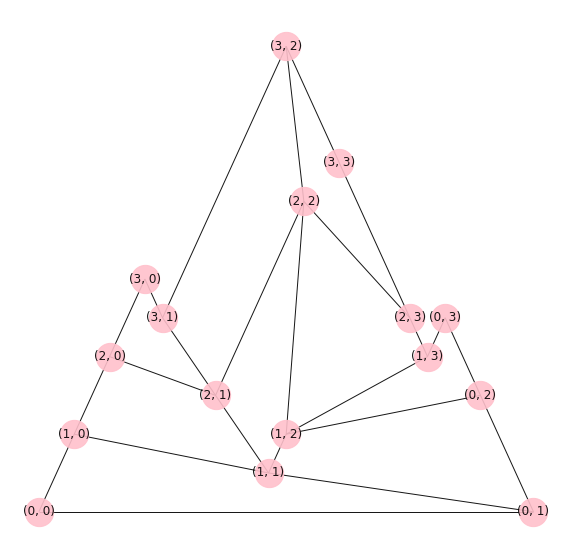

In [796]:
graph = nx.grid_2d_graph(4,4)


plt.figure(figsize=(10,10))    # pour définir la taille de la figure
pos = nx.planar_layout(graph)
nx.draw_networkx(graph,pos=pos,edge_color='black',width=1,linewidths=1,node_size=800,node_color='pink',alpha=0.9)
plt.axis('off')
plt.show()


In [806]:
node_list = list(graph.nodes)
trip1 = nx.shortest_path( graph, random.choice(node_list), random.choice(node_list))
trip2 = nx.shortest_path( graph, (1, 3), (1, 0))
print(trip2)
trip3 = nx.shortest_path( graph, (1, 0), (1, 3))
trip4 = list(((2,2),(1,2),(0,2),(0,1)))


[(1, 3), (1, 2), (1, 1), (1, 0)]


In [807]:
agentList = [RiderAgent(0,(1, 1),(1, 3)), DriverAgent(1, trip1), DriverAgent(2, trip2), DriverAgent(3, trip3), DriverAgent(4, trip4)]
sma = SMA(agentList, graph)
sma.runOnce()



 driver node tracker : {(0, 0): [], (0, 1): [(4, [(0, 1)], 3)], (0, 2): [(4, [(0, 2), (0, 1)], 2)], (0, 3): [], (1, 0): [(2, [(1, 0)], 3), (3, [(1, 0), (1, 1), (1, 2), (1, 3)], 0)], (1, 1): [(2, [(1, 1), (1, 0)], 2), (3, [(1, 1), (1, 2), (1, 3)], 1)], (1, 2): [(2, [(1, 2), (1, 1), (1, 0)], 1), (3, [(1, 2), (1, 3)], 2), (4, [(1, 2), (0, 2), (0, 1)], 1)], (1, 3): [(2, [(1, 3), (1, 2), (1, 1), (1, 0)], 0), (3, [(1, 3)], 3)], (2, 0): [], (2, 1): [], (2, 2): [(1, [(2, 2), (2, 3)], 0), (4, [(2, 2), (1, 2), (0, 2), (0, 1)], 0)], (2, 3): [(1, [(2, 3)], 1)], (3, 0): [], (3, 1): [], (3, 2): [], (3, 3): []}

 ad : {(1, 1): [(2, [(1, 1), (1, 0)], 2), (3, [(1, 1), (1, 2), (1, 3)], 1)]}
{(1, 1): {'distance': 0}}
(1, 1) {'distance': 0}
[(1, 1)]
0
2
1
{(1, 1): {'distance': 0}, (1, 0): {'distance': 2}, (1, 3): {'distance': 1}}
tick 1 ended


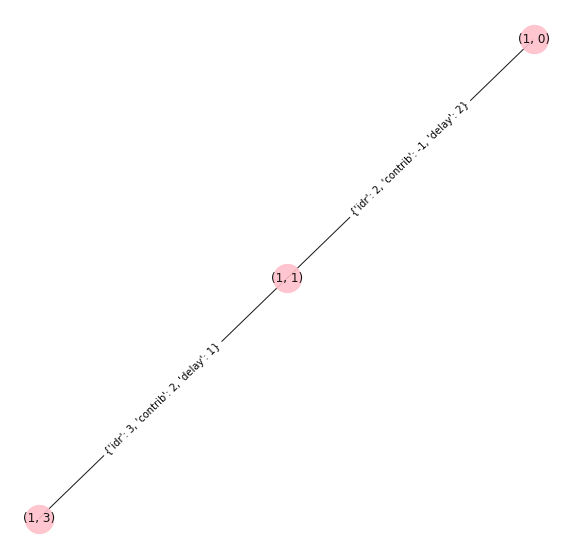

In [808]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))    # pour définir la taille de la figure
G_ts = sma.agentList[0].G_ts
pos = nx.spring_layout(G_ts)
nx.draw_networkx(G_ts,pos=pos,edge_color='black',width=1,linewidths=1,node_size=800,node_color='pink',alpha=0.9)
nx.draw_networkx_edge_labels(G_ts,pos=pos)
plt.axis('off')
plt.show()


In [809]:
print(G_ts.nodes)
for node in list(G_ts.nodes):
    print(node)
    print(G_ts.nodes[node])

[(1, 1), (1, 0), (1, 3)]
(1, 1)
{'distance': 0}
(1, 0)
{'distance': 2}
(1, 3)
{'distance': 1}


In [810]:
sma.runOnce()


 driver node tracker : {(0, 0): [], (0, 1): [(4, [(0, 1)], 2)], (0, 2): [(4, [(0, 2), (0, 1)], 1)], (0, 3): [], (1, 0): [(2, [(1, 0)], 2)], (1, 1): [(2, [(1, 1), (1, 0)], 1), (3, [(1, 1), (1, 2), (1, 3)], 0)], (1, 2): [(2, [(1, 2), (1, 1), (1, 0)], 0), (3, [(1, 2), (1, 3)], 1), (4, [(1, 2), (0, 2), (0, 1)], 0)], (1, 3): [(3, [(1, 3)], 2)], (2, 0): [], (2, 1): [], (2, 2): [], (2, 3): [(1, [(2, 3)], 0)], (3, 0): [], (3, 1): [], (3, 2): [], (3, 3): []}

 ad : {(1, 1): [(2, [(1, 1), (1, 0)], 1), (3, [(1, 1), (1, 2), (1, 3)], 0)], (1, 0): [(2, [(1, 0)], 2)], (1, 3): [(3, [(1, 3)], 2)]}
{(1, 1): {'distance': 0}, (1, 0): {'distance': 2}, (1, 3): {'distance': 1}}
(1, 1) {'distance': 0}
[(1, 1)]
(1, 0) {'distance': 2}
[(1, 1), (1, 0), (1, 3)]
(1, 3) {'distance': 1}
[(1, 1), (1, 0), (1, 3)]
0
2
1
{(1, 1): {'distance': 0}, (1, 0): {'distance': 2}, (1, 3): {'distance': 1}}
tick 2 ended


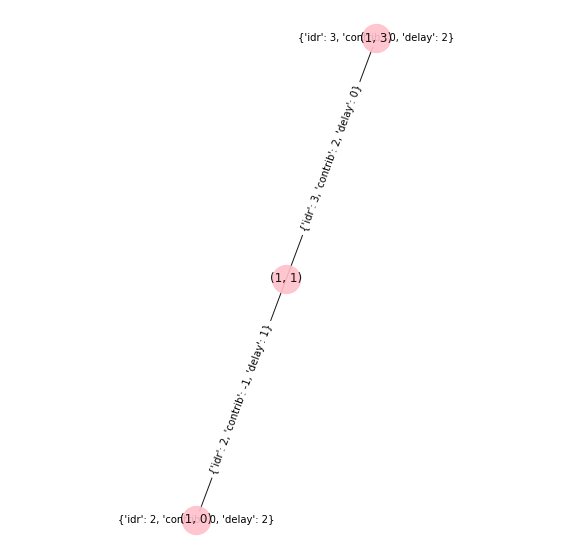

In [811]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))    # pour définir la taille de la figure
G_ts = sma.agentList[0].G_ts
pos = nx.spring_layout(G_ts)
nx.draw_networkx(G_ts,pos=pos,edge_color='black',width=1,linewidths=1,node_size=800,node_color='pink',alpha=0.9)
nx.draw_networkx_edge_labels(G_ts,pos=pos)
plt.axis('off')
plt.show()


# OLD
tout ce qui est au dessus me semble ok
je conserve le reste pour archive pour l'instant, et il y a le generateur qui etait pas mauvais normalement

In [ ]:
import random

class CarAgent():
    global bounds
    def __init__(self, unique_id, pos_dep):
        self.unique_id = unique_id
        self.pos = pos_dep
        self.new_pos = self.pos
        self.is_alive = True
        
    def update(self):
        direction = random.randrange(4)
        if direction == 0:
            self.new_pos = (self.pos[0]+1,self.pos[1])#EST
        elif direction == 1:
            self.new_pos = (self.pos[0],self.pos[1]-1)#SUD
        elif direction == 2:
            self.new_pos = (self.pos[0]-1,self.pos[1])#OUEST
        else :
            self.new_pos = (self.pos[0],self.pos[1]+1)#NORD

        # on vérifie que la nouvelle position est bien dans les limites de l'environnement sinon l'agent meurt
        if bounds[0]<=self.new_pos[0] or self.new_pos[0] <0 or  bounds[1]<=self.new_pos[1] or self.new_pos[1]<0:
            #global agentList
            #agentList.remove(self) # on ne peut pas faire ça sinon l'agent suivant remplace l'agent courant
            self.is_alive = False
            print("agent "+str(self.unique_id)+ " died")

    def decide(self):
        if self.is_alive == True :
            if self.pos == self.new_pos:
                print("Agent voiture n°",self.unique_id,"apparait en",self.pos)
            else :
                print("Agent voiture n°",self.unique_id,"bouge de",self.pos,"à",self.new_pos)
                self.pos = self.new_pos
        

In [ ]:
bounds = (10,10)
agentList = [CarAgent(1,(0,0)) , CarAgent(2,(5,5)), CarAgent(3,(8,8))]
tick = 0
for _ in range(10):
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
        
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            random.shuffle(agentList)
            agentList.remove(a) 
    print("tick",tick,"ended\n")
    tick+=1
        

In [ ]:
class RiderAgent():
    def __init__(self, unique_id, pos_dep, pos_arr):
        self.unique_id = unique_id
        self.pos = pos_dep
        self.new_pos = self.pos
        self.pos_arr = pos_arr
        self.waiting_time = 0
        self.is_alive = True

    #on vérifie si il y a un véhicule qui va dans notre direction
    def move(self, caragent):
        for car in caragent:
            if (self.pos[0] < self.pos_arr[0]) and (car.pos[0] < car.pos_arr[0]):
                return car
            elif (self.pos[0] > self.pos_arr[0]) and (car.pos[0] > car.pos_arr[0]):
                return car
            elif (self.pos[1] < self.pos_arr[1]) and (car.pos[1] < car.pos_arr[1]):
                return car
            elif (self.pos[1] > self.pos_arr[1]) and (car.pos[1] > car.pos_arr[1]):
                return car
        return None

    def update(self):
        ##On vérifie si il y a quelqu'un sur notre case, sinon ça ne sert à rien d'agir
        global agentList
        caragent = [agent for agent in agentList if (agent.__class__.__name__ == "CarAgent" and agent.pos == self.pos)]
        if len(caragent) > 0:
            new_car = self.move(caragent)
            if new_car != None:
                self.new_pos = new_car.new_pos
            else :
                self.new_pos = self.pos
        else :
            self.new_pos = self.pos
    
    def decide(self):
        #print("Agent Rider:", self, self.pos, self.pos_arr, self.new_position)
        if self.new_pos != self.pos :
            self.pos = self.new_pos
            #on vérifie si le passager est arrivé à destination
            if self.pos == self.pos_arr:
                print("Agent passager n°",self.unique_id," arrivé à destination avec un temps total d'attente de:",self.waiting_time)
                self.is_alive = False
        else :
            self.waiting_time += 1

# A ton besoin de simultanéité ?
Voici un petit bout de code permettant de prouver le besoin de simultanéité, en effet comme précisé plus haut, si l'on donne le tour de parole aléatoirement au agents, il se peu qu'un agent effectue deux fois son tour de parole d'affilé :

type de config :

--tick 0
agent 1 puis agent 2


--tick 1
agent 2 puis agent 1

In [ ]:
bounds = (10,10)
agentList = [CarAgent(1,(0,0)) , CarAgent(2,(5,5)), CarAgent(3,(8,8)), RiderAgent(4,(5,5),(5,9))]
tick = 0
for _ in range(10):
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
        
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            random.shuffle(agentList)
            agentList.remove(a) 
    print("tick",tick,"ended\n")
    tick+=1
        

### Les générateurs de véhicules

Afin d'avoir un flux continu de véhicules, il est nécessaire de générer de nouveaux véhicules régulièrement. c'est le role des agents `Generator`.

In [ ]:
import random

class Generator() :
    global bounds
    global tick
    def __init__(self, unique_id, frequence, nb_cars):
        self.unique_id = unique_id
        self.frequence = frequence #generation tout les "frequence" ticks
        self.nb_cars = nb_cars
        self.is_alive = True
        
    def update(self): 
        if tick == 0 or (self.frequence % tick) :
            genList = []
            for _ in range(self.nb_cars):
                global id_count
                id_count += 1
                genList.append(CarAgent(id_count, (random.randrange(bounds[0]),random.randrange(bounds[1]))))
            
            global agentList
            agentList = agentList + genList
        else:
            pass
    
    def decide(self):
        pass
    

In [ ]:
bounds = (10,10)
agentList = []
id_count = 0
tick = 0
gen = Generator(0, 5, 5)
agentList = [gen]
for _ in range(5):
    random.shuffle(agentList)
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            agentList.remove(a) 
    print("tick",tick)
    tick += 1

In [ ]:
class RiderAgent():
    def __init__(self, unique_id, pos_dep, pos_arr):
        self.unique_id = unique_id
        self.pos = pos_dep
        self.new_pos = self.pos
        self.pos_arr = pos_arr
        self.waiting_time = 0
        self.is_alive = True

    #on vérifie si il y a un véhicule qui va dans notre direction
    def move(self, caragent):
        for car in caragent:
            if (self.pos[0] < self.pos_arr[0]) and (car.pos[0] < car.pos_arr[0]):
                return car
            elif (self.pos[0] > self.pos_arr[0]) and (car.pos[0] > car.pos_arr[0]):
                return car
            elif (self.pos[1] < self.pos_arr[1]) and (car.pos[1] < car.pos_arr[1]):
                return car
            elif (self.pos[1] > self.pos_arr[1]) and (car.pos[1] > car.pos_arr[1]):
                return car
        return None

    def update(self):
        ##On vérifie si il y a quelqu'un sur notre case, sinon ça ne sert à rien d'agir
        global agentList
        caragent = [agent for agent in agentList if (agent.__class__.__name__ == "CarAgent" and agent.pos == self.pos)]
        if len(caragent) > 0:
            new_car = self.move(caragent)
            if new_car != None:
                self.new_pos = new_car.new_pos
            else :
                self.new_pos = self.pos
        else :
            self.new_pos = self.pos
    
    def decide(self):
        #print("Agent Rider:", self, self.pos, self.pos_arr, self.new_position)
        if self.new_pos != self.pos :
            self.pos = self.new_pos
            #on vérifie si le passager est arrivé à destination
            if self.pos == self.pos_arr:
                print("Agent passager n°",self.unique_id," arrivé à destination avec un temps total d'attente de:",self.waiting_time)
                self.is_alive = False
        else :
            self.waiting_time += 1

# A ton besoin de simultanéité ?
Voici un petit bout de code permettant de prouver le besoin de simultanéité, en effet comme précisé plus haut, si l'on donne le tour de parole aléatoirement au agents, il se peu qu'un agent effectue deux fois son tour de parole d'affilé :

type de config :

--tick 0
agent 1 puis agent 2


--tick 1
agent 2 puis agent 1

In [ ]:
bounds = (10,10)
agentList = [RiderAgent(0, (5,5), (5,0)),]
tick = 0


agentList = [gen]
for _ in range(5):
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            agentList.remove(a) 
    print("tick",tick)
    tick += 1


On a une grille. Un générateur de véhicules qui génère selon une loi de probabilité des véhicules sur l'un des axes dans l'un des sens. Simultanément apparaissent des passagers à un lei aléatoire pour une destination aléatoire (X,Y).
Les véhicules sont réputés toujours aller jusqu'au bout d'un axe et peuvent descendre un passager où ils veulent (c'est un bus ou un train). Le système est rythmé par unités de temps (ticks). Avancer d'une case prend 1 tick, et donc attendre un véhicule qui est 2 cases plus loin prend 2 ticks.


## Le SMA

In [ ]:
import random
class SMA:
    def __init__(self, bounds):
        self.tick=0
        self.resetTicks()
        self.agentList = []
        #self.gen = gen # on associe le générateur au sma, c'est plus simple
        self.bounds = bounds
        self.collector = [] # on collecte ici les temps d'attente

    def resetTicks(self):
        tick=0
          
    def addAgent(self,ag):
        self.agentList.append(ag)
 
    def run(self,rounds):
        for i in range(0,rounds):
            self.runOnce()
    
    def runOnce(self):
        self.tick+=1
        gen.generate_agent()
        random.shuffle(self.agentList)
        #on calcule les prochains positions des voitures
        for ag in self.agentList :
            ag.cars_new_pos()
        #on determine si les passagers vont bouger ou non
        for ag in self.agentList :
            ag.riders_new_pos()
        #on actualise la position des agents
        for ag in self.agentList :
            ag.agents_update_pos()
            
        #print("tick "+str(self.tick)+" ended")

In [ ]:
#bounds = (10,10)
#agentList = []
#id_count = 0
#tick = 0
gen = Generator(0, 5, 5)
agentList = [gen]
for _ in range(5):
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            agentList.remove(a) 
    print("tick",tick)
    tick += 1

## L'environnement


Au final, on a pas du tout besoin d'une grille, dans le sens ou on l'on peut fonctionner juste avec les coordonnées des agents dans l'espace.

## Les agents

In [ ]:
class Agent:
    """ Pour pouvoir manipuler facilement les agents dans le sma, on creer une sorte d'abstract class """

    def __init__(self, unique_id: int, dep: (int, int), dest: (int,int)) -> None:
        self.unique_id = unique_id
        self.pos = dep
        self.pos_arr = dest
        self.new_pos = self.pos
    
    def cars_new_pos(self) -> None:
        pass

    def riders_new_pos(self) -> None:
        pass

    def agents_update_pos(self) -> None:
        pass

### Les véhicules

In [ ]:
class CarAgent(Agent):
    def __init__(self, unique_id, pos_dep, pos_arr):
        super().__init__(unique_id, pos_dep, pos_arr)
        
    def move(self):
        if self.pos[0] == self.pos_arr[0]:
            if self.pos[1] == self.pos_arr[1]:
                #print("Agent voiture n°",self.unique_id," arrivée à destination.")
                sma.agentList.remove(self)
                return
            elif self.pos[1] > self.pos_arr[1]:
                new_position = (self.pos[0],self.pos[1]-1)
            else : 
                new_position = (self.pos[0],self.pos[1]+1)
        elif self.pos[0] > self.pos_arr[0]:
            new_position = (self.pos[0]-1,self.pos[1])
        else : 
            new_position = (self.pos[0]+1,self.pos[1])
        
       
        self.new_pos = new_position
        
        
        
    def cars_new_pos(self):
        self.move()

    def riders_new_pos(self):
        pass

    def agents_update_pos(self):
        #print("Agent voiture n°",self.unique_id," bouge de ",self.pos," à ",self.new_pos)
        self.pos = self.new_pos

Les véhicules vont donc uniquement dans une direction, à chaque ticks ils regardent dans quel sens ils sont sensé aller et bougent d'une case.

### Les passagers

In [ ]:
class RiderAgent(Agent):
    def __init__(self, unique_id, pos_dep, pos_arr):
        super().__init__(unique_id, pos_dep, pos_arr)
        self.waiting_time = 0

    #on vérifie si il y a un véhicule qui va dans notre direction
    def move(self, caragent):
        for car in caragent:
            if (self.pos[0] < self.pos_arr[0]) and (car.pos[0] < car.pos_arr[0]):
                return car
            elif (self.pos[0] > self.pos_arr[0]) and (car.pos[0] > car.pos_arr[0]):
                return car
            elif (self.pos[1] < self.pos_arr[1]) and (car.pos[1] < car.pos_arr[1]):
                return car
            elif (self.pos[1] > self.pos_arr[1]) and (car.pos[1] > car.pos_arr[1]):
                return car
        return None
    
    def cars_new_pos(self):
        pass

    def riders_new_pos(self):
        if self.pos == self.pos_arr:
            #print("Agent passager n°",self.unique_id," arrivé à destination avec un temps total d'attente de:",self.waiting_time)
            sma.collector.append(self.waiting_time)
            sma.agentList.remove(self)
            return
        
        ##On vérifie si il y a quelqu'un sur notre case, sinon ça ne sert à rien d'agir
        caragent = [agent for agent in sma.agentList if (agent.__class__.__name__ == "CarAgent" and agent.pos == self.pos)]
        if len(caragent) > 0:
            new_car = self.move(caragent)
            if new_car != None:
                self.new_pos = new_car.new_pos
            else :
                self.new_pos = self.pos
        else :
            self.new_pos = self.pos
    
    def agents_update_pos(self):
        #print("Agent Rider:", self, self.pos, self.pos_arr, self.new_position)
        if self.new_pos != self.pos :
            self.pos = self.new_pos
        else :
            self.waiting_time += 1

A chaque tour, les agents passagers collectent le ou les agents voiture présent sur sa case, et prends celui qui va dans sa direction.

## Les générateurs de véhicules

In [ ]:
# Mettre ici le code d'un générateur trivial
import random
class Generator():
    def __init__(self, height, width, nb_car_x, nb_car_y, nb_rider):
        self.height = height
        self.width = width
        self.nb_car_x = nb_car_x
        self.nb_car_y = nb_car_y
        self.nb_rider = nb_rider
        self.n_id = -1
    
    def next_id(self):
        self.n_id += 1
        return self.n_id
    
    #genere les agents voitures a l'horizontal
    def XAgentGenerator(self):
        x = random.choice([0, self.width - 1])
        y = random.randrange(self.height)
        pos_dep = (x, y)
        pos_arr = (abs(x - self.width + 1), y)

        a = CarAgent(self.next_id(), pos_dep, pos_arr)
        sma.addAgent(a)
        
        
    #genere les agents voitures a la vertical
    def YAgentGenerator(self):
        x = random.randrange(self.width)
        y = random.choice([0, self.height - 1])
        pos_dep = (x, y)
        pos_arr = (x, abs(y - self.height + 1))

        a = CarAgent(self.next_id(), pos_dep, pos_arr)
        sma.addAgent(a)

    #genere les agents passagers a des positions aleatoire
    def RiderAgentGenerator(self):
        x = random.randrange(self.height)
        y = random.randrange(self.width)

        pos_dep = (x, y)
        x_p = random.randrange(self.height)
        y_p = random.randrange(self.width)
        pos_arr = (x_p, y_p)
        a = RiderAgent(self.next_id(), pos_dep, pos_arr)
        sma.addAgent(a)
    
    #fonction qui genere les agents en fonction des valeurs choisis
    def generate_agent(self):
       
        for _ in range(random.randrange(self.nb_car_x)):
            self.XAgentGenerator()
        for _ in range(random.randrange(self.nb_car_y)):
            self.YAgentGenerator()
        for _ in range(random.randrange(self.nb_rider)):
            self.RiderAgentGenerator()
    

# Une première version
Un passager est aveugle. Il monte dans le premier véhicule qui se présente dans sa direction (soit verticale soit horizontale) et il va jusqu'au maximum de sa possibilité (son X ou son Y de destination). Il se déplace dans une direction 1 fois, descend du véhicule, attend le prochain véhicule dans l'autre sens et arrive à sa destination.
Précisions :
- au maximum il attend 2 fois : au départ, et au changement
- grâce au rythme du système on est capable de tracer des courbes de temps d'attente (en tick)



In [ ]:
gen = Generator(10, 10, 5, 5, 5)
sma = SMA(gen)
sma.run(1000)


In [ ]:
import numpy as np
print("Le temps d'attente moyen est de",np.mean(sma.collector), "ticks")

Experience : faire varier le nombre de véhicule

In [ ]:
import matplotlib.pyplot as plt
range_vehicules = np.arange(5,50,5)
nb_passagers = 5

big_collector = []

for nb_vehicule in range_vehicules:
    gen = Generator(10, 10, nb_vehicule, nb_vehicule, 5)
    sma = SMA(gen)
    sma.run(1000)
    big_collector.append(np.mean(sma.collector))
    
plt.xlabel("Nombre de conducteur")
plt.ylabel("Nombre moyen de ticks d'attente")
plt.plot(range_vehicules,big_collector)

# Une version plus poussée

Le passager perçoit une partie de l'environnement : sa verticale et son horizontale. Quand un véhicule arrive dans sa case, il regarde le nombre de cases N que ce véhicule lui permet de faire (N=X ou N=Y), et si il y a dans sa perception un autre véhicule à T distance qui lui permettra d'avancer d'un nombre de cases U (dans l'autre direction), avec U-T > N alors il attend celui là (Corwin raisonne sur un "potentiel" : U-T c'est le potentiel de cases dans l'autre direction avec un taux de transfert 0).
Une fois dans le véhicule, le passager fait ce raisonnement là à chaque case, et donc, décide de descendre ou pas, pour en attendre un autre.
Précisions :
- la formule de choix mise en place pourrait être inversée ! c'est une heuristique ! Il y a des heuristiques optimistes et des heuristiques pessimistes (ne serait-ce qu'en inversant l'inégalité).
- Dans cette version le passager peut donc voyager en zig-zag, néanmoins il ne "dépasse" jamais son X et son Y.


# Bibliographie

Philippe Mathieu, Yann Secq.
Environment Updating and Agent Scheduling Policies in Agent-based Simulators. 
ICAART Conference, 2012, pp 170-175

Philippe Mathieu, Sébastien Picault, Yann Secq.
Design Patterns for Environments in Multi-agent Simulations. 
PRIMA Conference, 2015, pp 678-686

Philippe Mathieu, Gildas Morvan, Sébastien Picault.
Multi-level agent-based simulations: Four design patterns. 
Journal of Simulation Modelling Practice and Theory, Janv 2018
